In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
#PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'

act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

current_version = 0 #June 23nd, 2023
current_version = 1 # July 21st 2023

stdfont = 14
stdyfrac = 0.06


In [53]:
#animals = np.concatenate((dualanimalnames,[]))
animals = ['AE_344','AE_346','AE_367','AE_350','AE_351','AE_359']

In [54]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

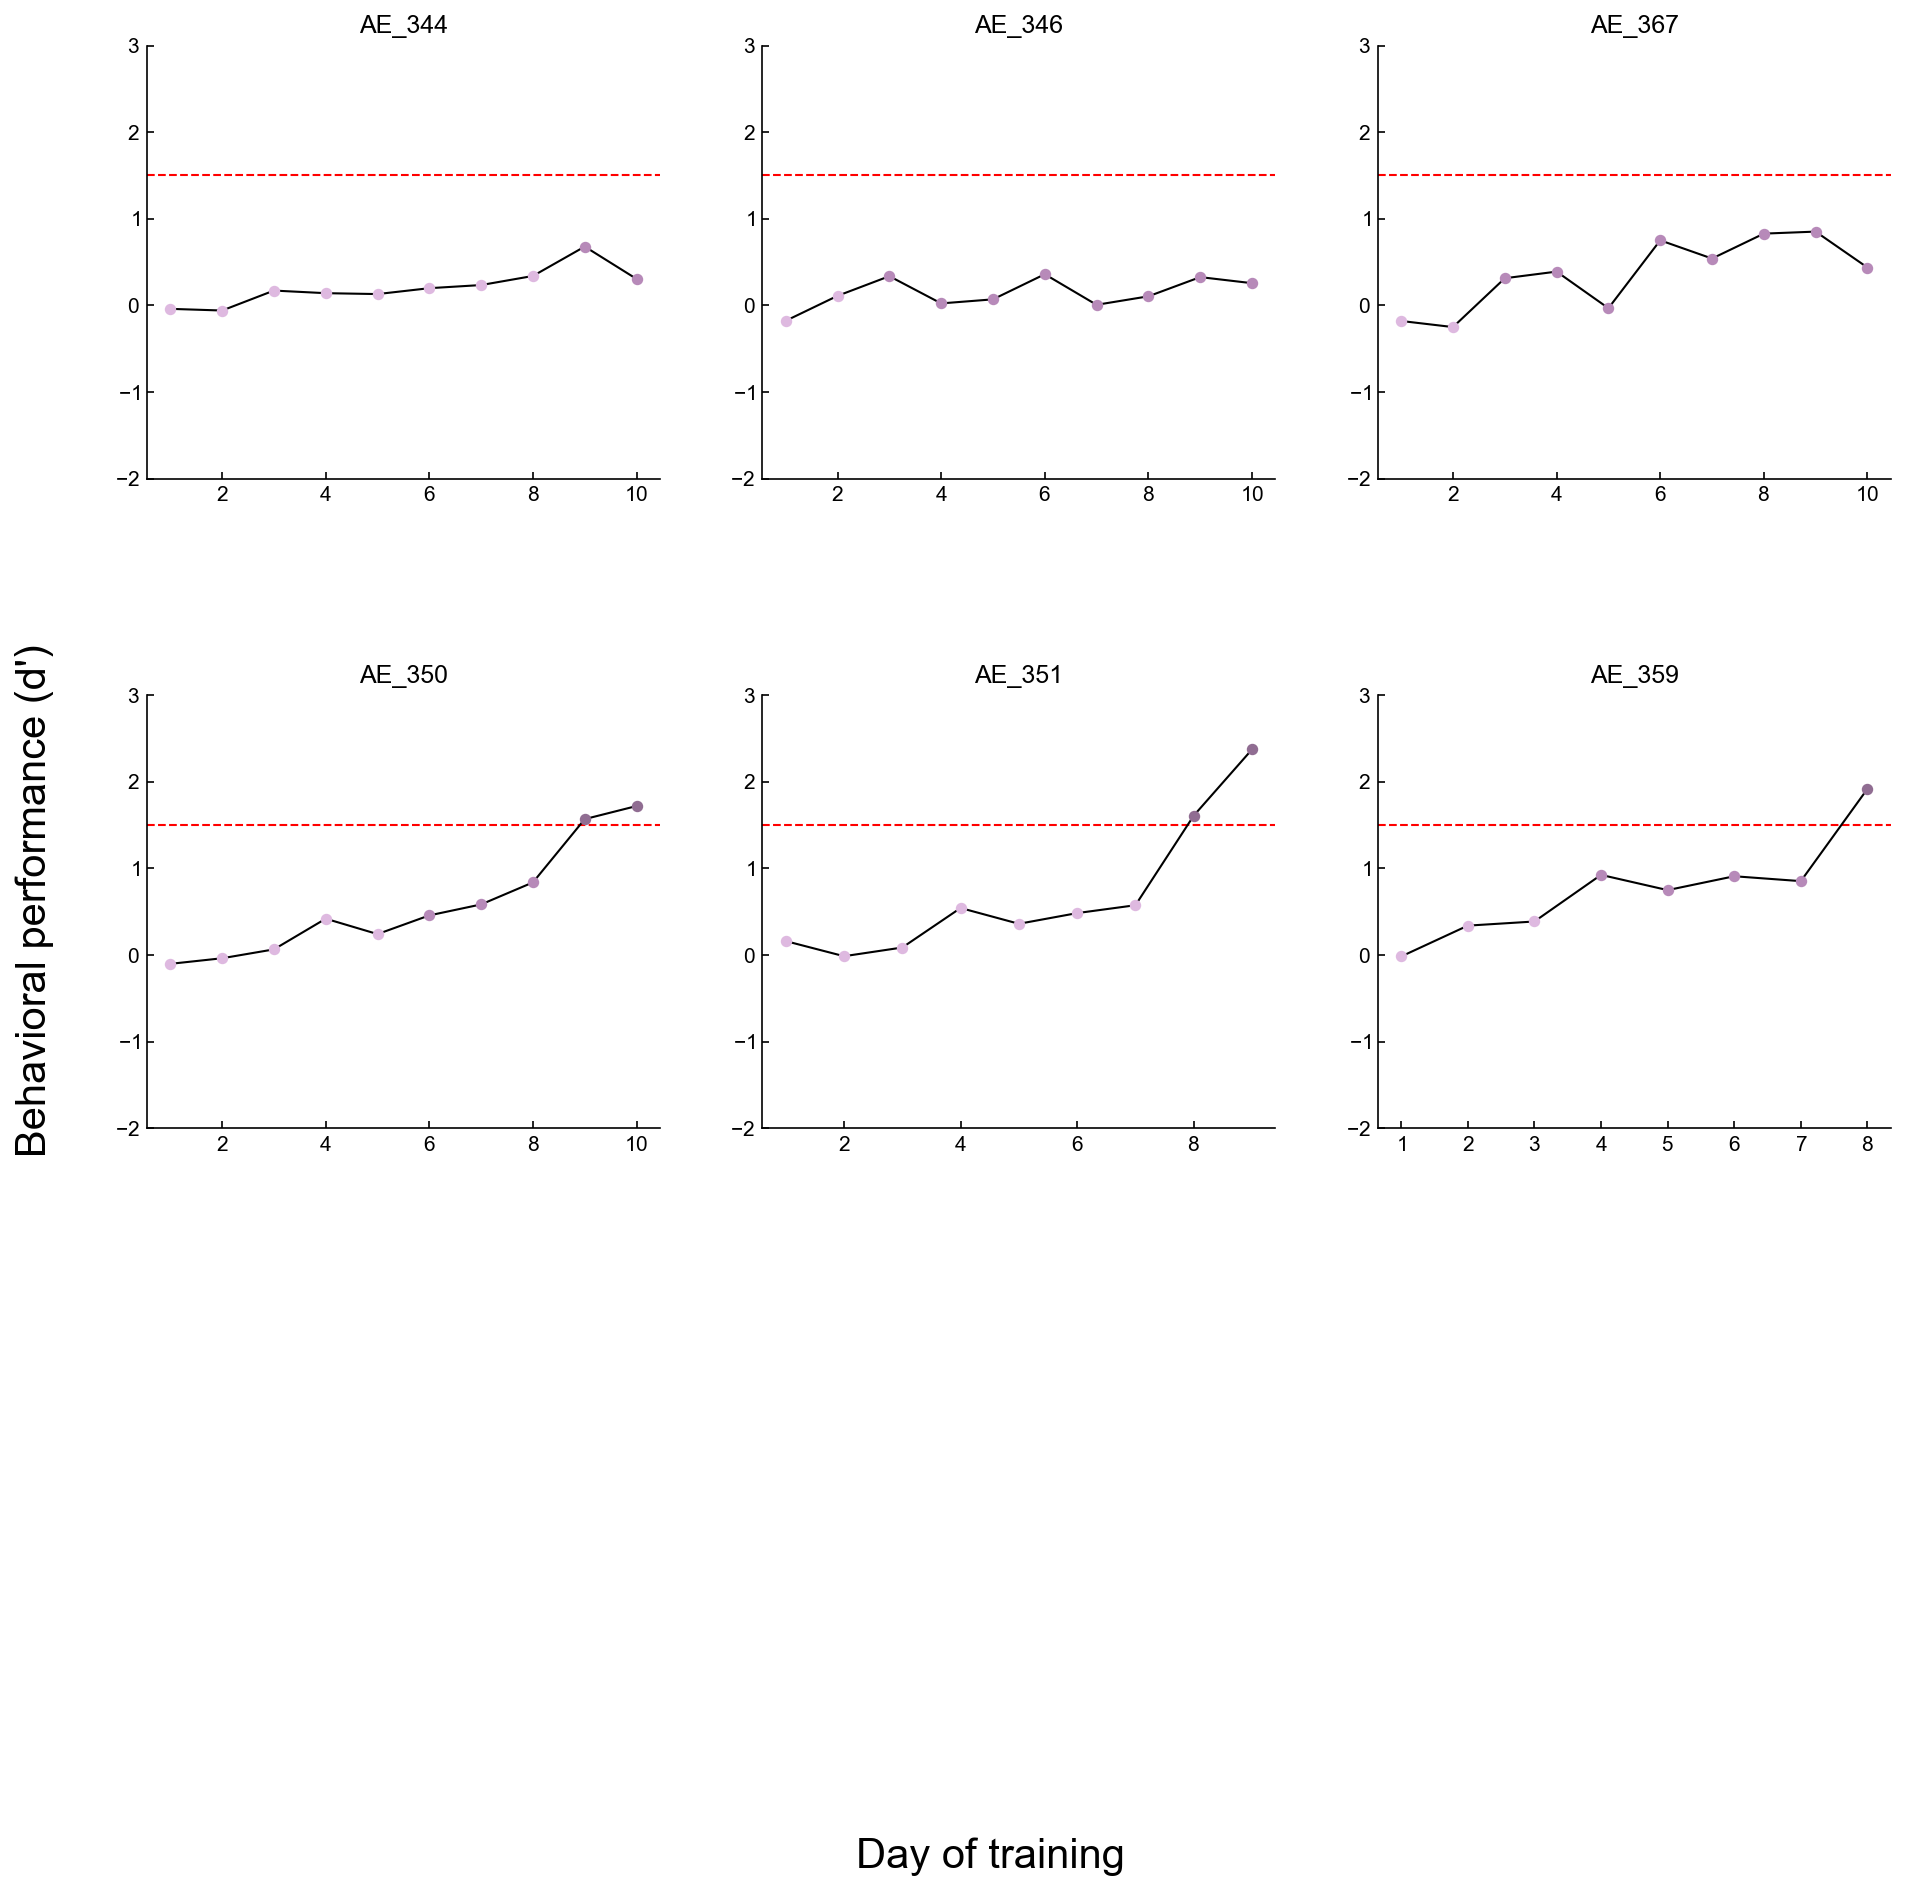

In [55]:
animalPhases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [5]:
animal_list = []
day_list = []
dp_total_list = []
phase_list = []

animallist = ['AE_344','AE_346','AE_367']
for animal in animallist:
    reversal = animalBehaviors[animal].reversal
    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)
    days = np.sort(days)

    for idx,day in enumerate(days):
        phase = 'N/A'
        if day in animalPhases[animal].pre_early_days:
            phase = 'pre early'
        elif day in animalPhases[animal].pre_late_days:
            phase = 'pre late'
        elif day in animalPhases[animal].pre_expert_days:
            phase = 'pre expert'
        elif day == reversal:
            phase = 'switch'
        elif day in animalPhases[animal].post_early_days:    
            phase = 'post early'
        elif day in animalPhases[animal].post_late_days:
            phase = 'post late'
        elif day in animalPhases[animal].post_expert_days:
            phase = 'post expert'

        if phase == 'N/A':
            continue
            #This hits only BS_40 day 17. Excluded due to animal's poor motivation
        
        animal_list.append(animal)
        day_list.append(day)
        dp_total_list.append(dp_list[idx])
        phase_list.append(phase)

In [6]:
df_dict = dict()
df_dict['animal'] = animal_list
df_dict['session'] = day_list
df_dict['d\''] = dp_total_list
df_dict['learning phase'] = phase_list
df = pd.DataFrame(df_dict)

In [7]:
df

,animal,session,d',learning phase
0,AE_344,1,-0.040102,pre early
1,AE_344,2,-0.059415,pre early
2,AE_344,3,0.170955,pre early
3,AE_344,4,0.140812,pre early
4,AE_344,5,0.130571,pre early
5,AE_344,6,0.198428,pre early
6,AE_344,7,0.234597,pre early
7,AE_344,8,0.339460,pre early
8,AE_344,9,0.678773,pre late
9,AE_344,10,0.305057,pre late


In [8]:
df.to_csv('..\\..\\Source Data Files\Pre Opto Learning Phases.csv')

In [48]:
def animal_learning_curve_reconstructed(animal):
    rev = animalBehaviors[animal].reversal
    max_day = len(animalBehaviors[animal].sessions)
    print(rev)
    print(max_day)

    fig, ax = plt.subplots(figsize=(5,4.5))
    PLOTTING_PHASE_COLORS = PHASE_COLORS

    df_animal = df[df['animal'] == animal]
    days = df_animal['session']
    
    pre_early = df_animal['learning phase'] == 'pre early'
    pre_late = df_animal['learning phase'] == 'pre late'
    pre_expert = df_animal['learning phase'] == 'pre expert'
    switch = df_animal['learning phase'] == 'switch'
    post_early = df_animal['learning phase'] == 'post early'
    post_late = df_animal['learning phase'] == 'post late'
    post_expert = df_animal['learning phase'] == 'post expert'
    
    # reversal = days[switch]
    # expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list = df_animal['d\'']

    ax.plot(days,dp_list,color='k',lw=1)

    circle_size = 60

    #Pre Early
    # pre_early = np.isin(days,animalPhases[animal].pre_early_days)
    ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10,clip_on=False)

    #Pre Late
    # pre_late = np.isin(days,animalPhases[animal].pre_late_days)
    ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10,clip_on=False)

    #Pre Expert
    # pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
    ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10,clip_on=False)

    # #Post Early
    # # post_early = np.isin(days,animalPhases[animal].post_early_days)
    # ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

    # #Post Late
    # # post_late = np.isin(days,animalPhases[animal].post_late_days)
    # ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)

    # #Post Expert
    # # post_expert = np.isin(days,animalPhases[animal].post_expert_days)
    # ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)

    # #Switch
    # # switch = np.equal(days,animalBehaviors[animal].reversal)
    # ax.scatter(days[switch],dp_list[switch],color=SWITCH_COLOR,s=circle_size,zorder=10)
    ax.set_ylim([-2,3])
    ax.set_yticks([-2,-1,0,1,2,3])

    ax.set_xlim([0,10])
    ax.set_xticks(range(0,9))
    # for index, label in enumerate(ax.xaxis.get_ticklabels()):
    #     #labeledindex = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41]
    #     #labeledindex = [1,5,9,13,17,21,25,29,33,37,41]
    #     labeledindex = [1,5,10]
    #     if index not in labeledindex:
    #         label.set_visible(False)
            
    ax.tick_params(length=6)

    # size = 0.5
    # center = np.mean(ax.get_ylim())
    # ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
    # ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
    # ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

    ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
    print(reversal)
    ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
    ax.text(7,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
    # ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
    # ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
    # ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
    # ax.text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

    ax.set_ylabel("Behavioral performance (d') ")
    ax.set_xlabel('Sessions')
    ax.set_axisbelow(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    #These must be changed at the end. brokenaxes recalculates ticks for several calls
    ax.set_xticks(range(0,max_day+1))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass
    
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_19.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_15.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_40.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_108.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript\\Learning'+animal+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

inf
10
inf


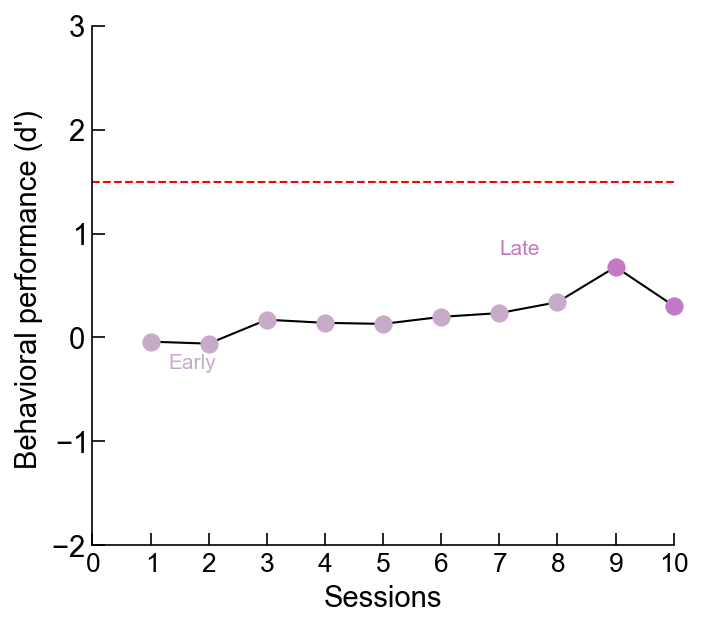

In [49]:
animal_learning_curve_reconstructed('AE_344')

inf
10
inf


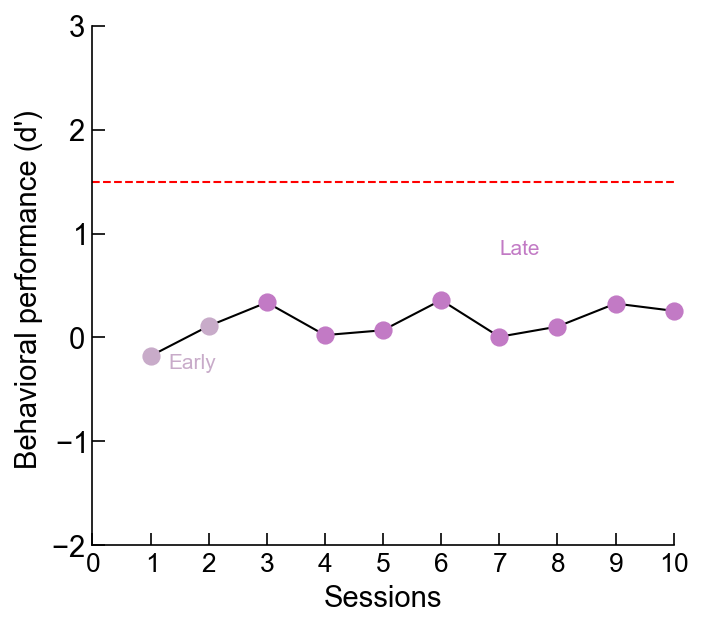

In [51]:
animal_learning_curve_reconstructed('AE_346')

inf
10
inf


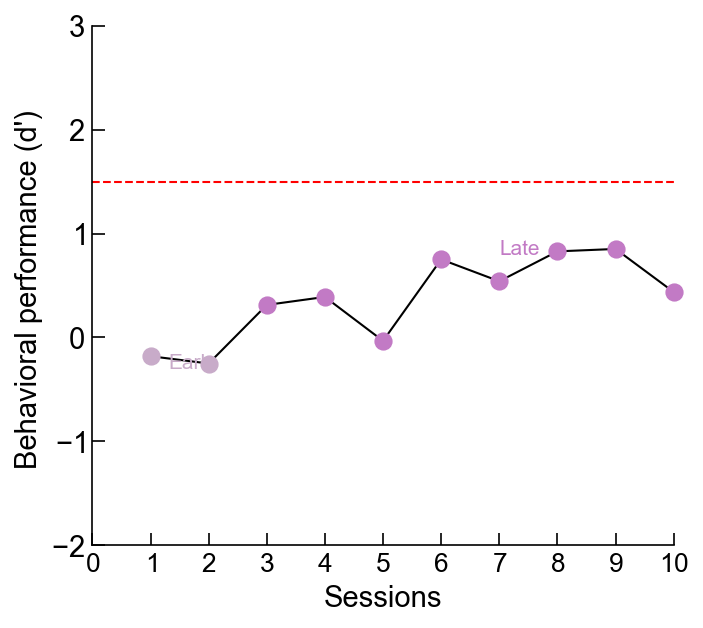

In [52]:
animal_learning_curve_reconstructed('AE_367')